<a href="https://colab.research.google.com/github/SunSad63/TSML/blob/main/TSML_21_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

In [27]:
monthly_sales_of_company = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")['Count']
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")['Count']
airlines_passengers = pd.read_csv("international-airline-passengers.csv")['Count']
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")['Deg']
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")['Close']
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")['Count']

In [28]:
### Тест Дики-Фуллера
######################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [29]:
### отрисовка ряда
### тест
### Коррелограммы
###################

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [30]:
## СЕЗОННОСТЬ
#############

def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)

    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

In [31]:
## скользящее среднее (МА)
#############

def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [36]:
### взвешенное скользящее средне (wma)
#############

def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [45]:
### экспоненциальное сглаживание (EMA)
#############

def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [52]:
### двойное экспоненциальное сглаживание (DEMA)
##################

def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)


# Анализ данных "monthly-boston-armed-robberies-j.csv"

In [61]:
serias_orig = robberies_in_boston

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


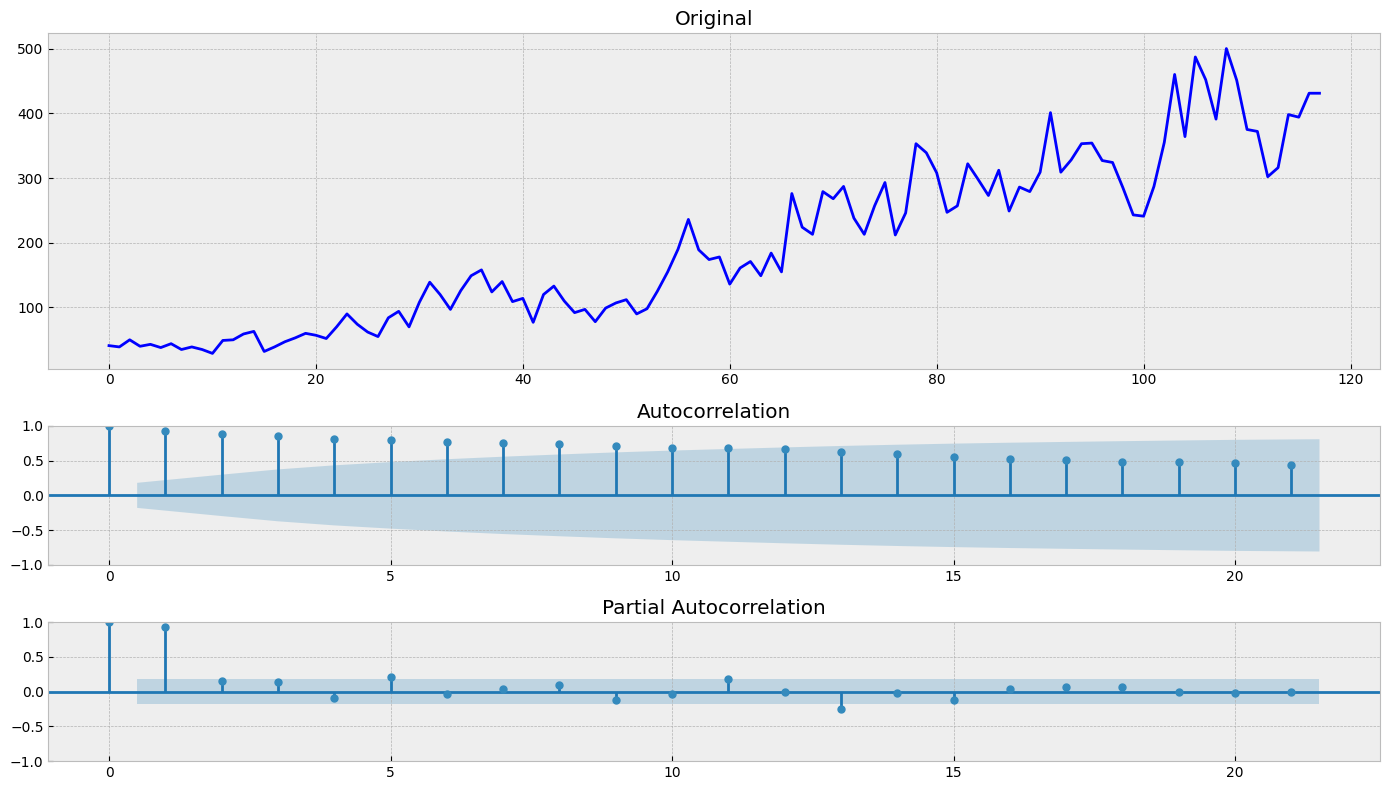

In [62]:
tsplot(serias_orig)

Results of Dickey-Fuller Test:
Test Statistic                  -2.013161
p-value                          0.280833
#Lags Used                      10.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


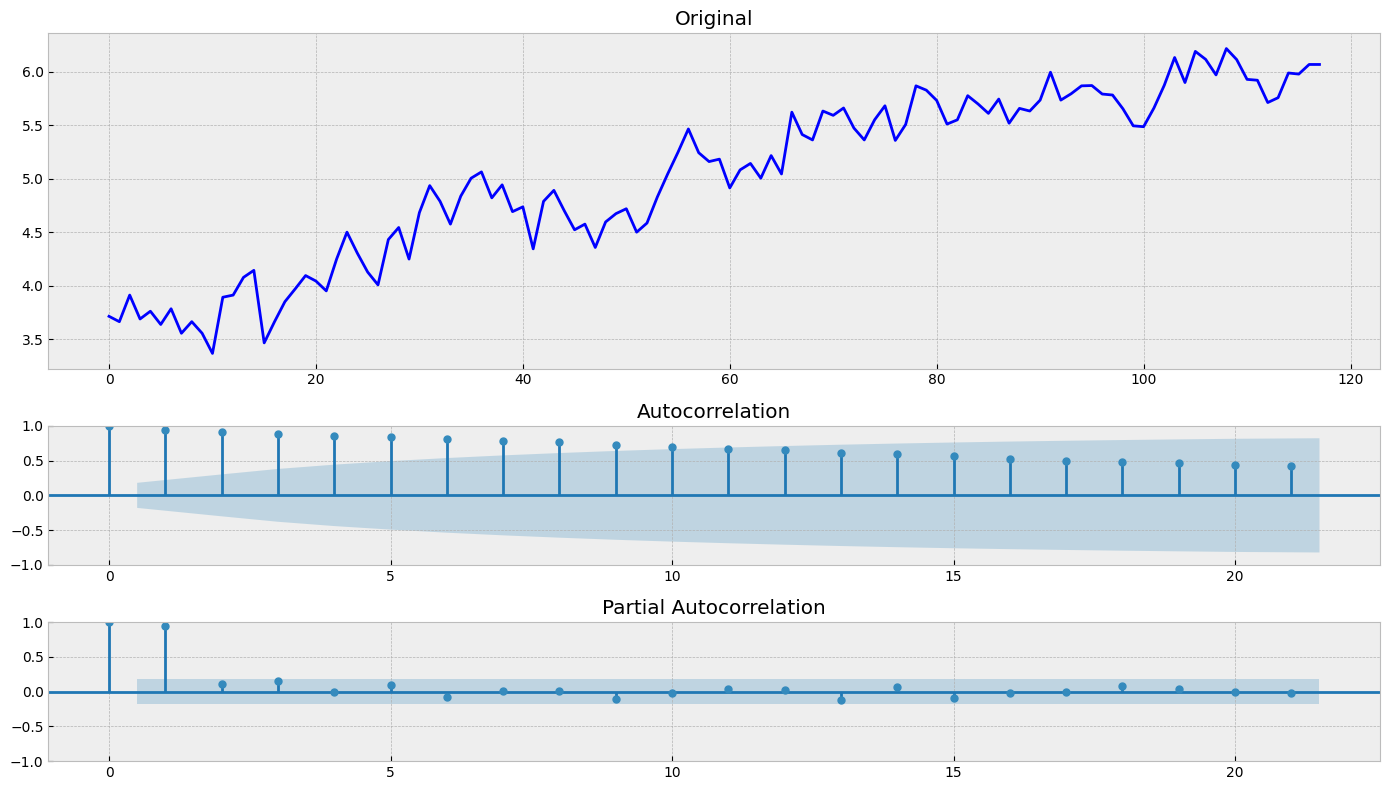

In [81]:
series_stat = boxcox(robberies_in_boston, 0)
tsplot(series_stat)

Results of Dickey-Fuller Test:
Test Statistic                -6.571432e+00
p-value                        7.918035e-09
#Lags Used                     1.200000e+01
Number of Observations Used    1.030000e+02
Critical Value (1%)           -3.495493e+00
Critical Value (5%)           -2.890037e+00
Critical Value (10%)          -2.581971e+00
dtype: float64


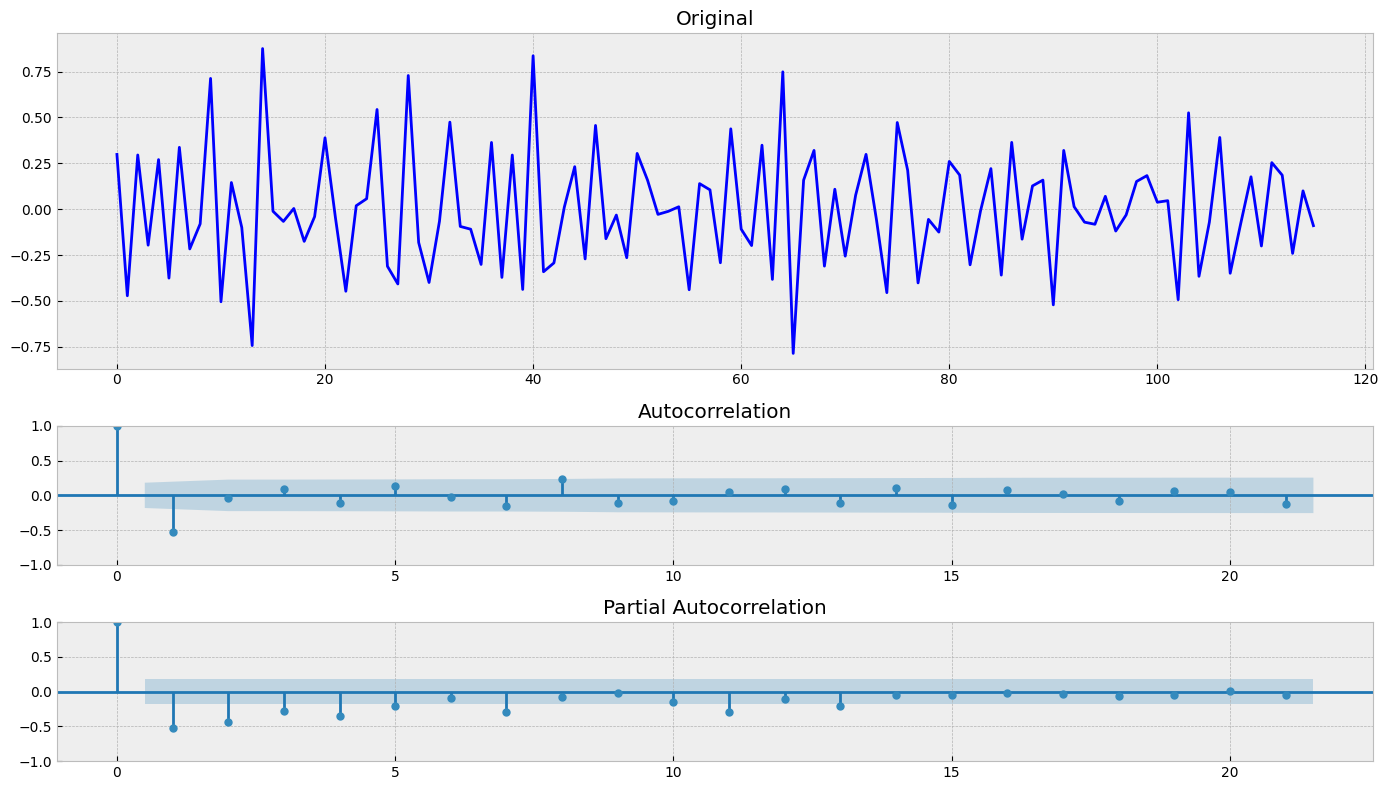

In [101]:
series_stat = np.diff(series_stat, 1) # дифференцирование
tsplot(series_stat)

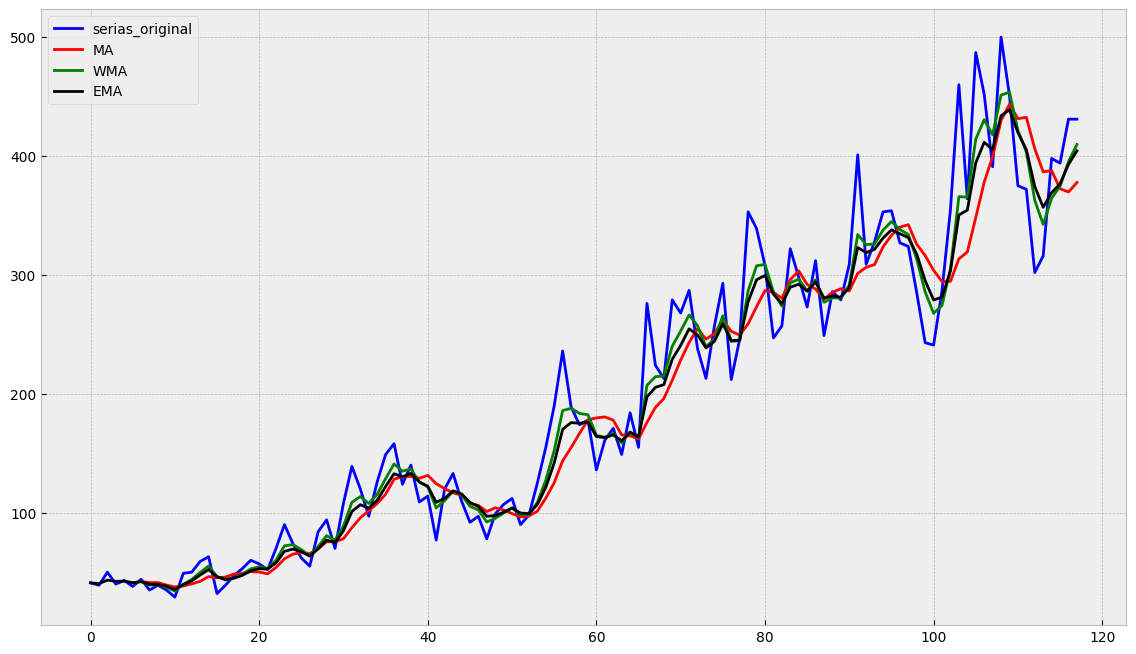

In [104]:
ema = exponential_moving_average(serias_orig, 0.3)
wma = weighted_moving_average(serias_orig, 7, [1,1,2,3,5,8,13])
ma = moving_average(serias_orig, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(serias_orig, color='blue',label='serias_original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

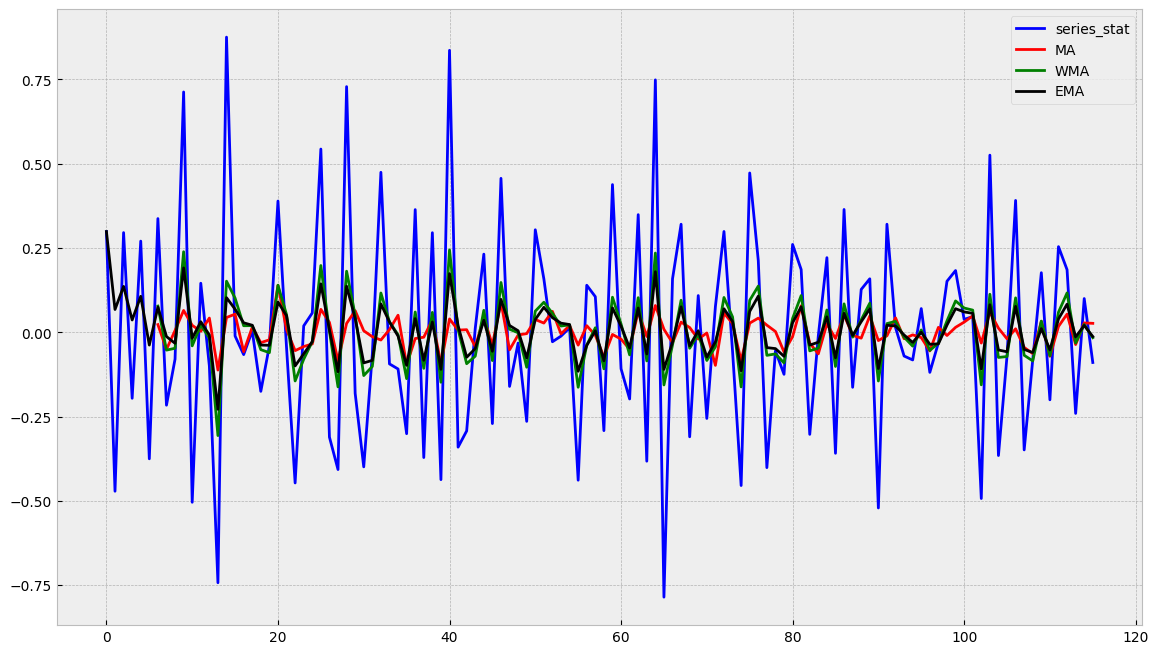

In [105]:
ema = exponential_moving_average(series_stat, 0.3)
wma = weighted_moving_average(series_stat, 7, [1,1,2,3,5,8,13])
ma = moving_average(series_stat, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stat, color='blue',label='series_stat')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

In [67]:
def plot_dema(serias, alpha, beta):
    dema = double_ema(serias, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(serias, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title('serias')
        plt.legend()

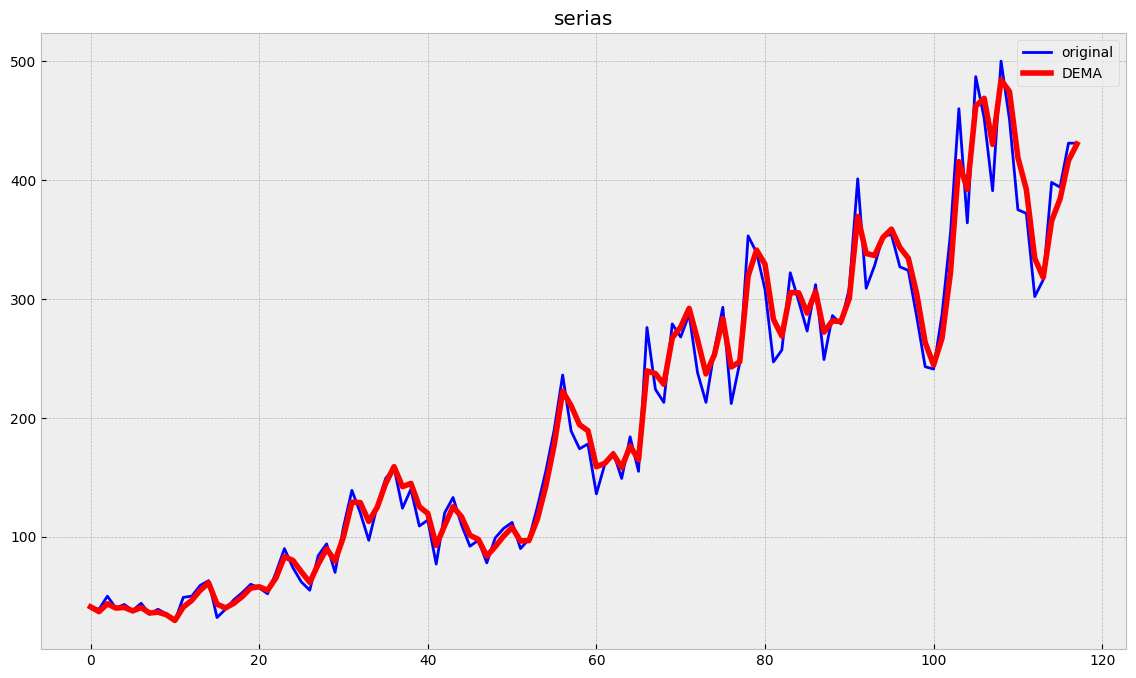

In [97]:
plot_dema(serias_orig, 0.6, 0.1)

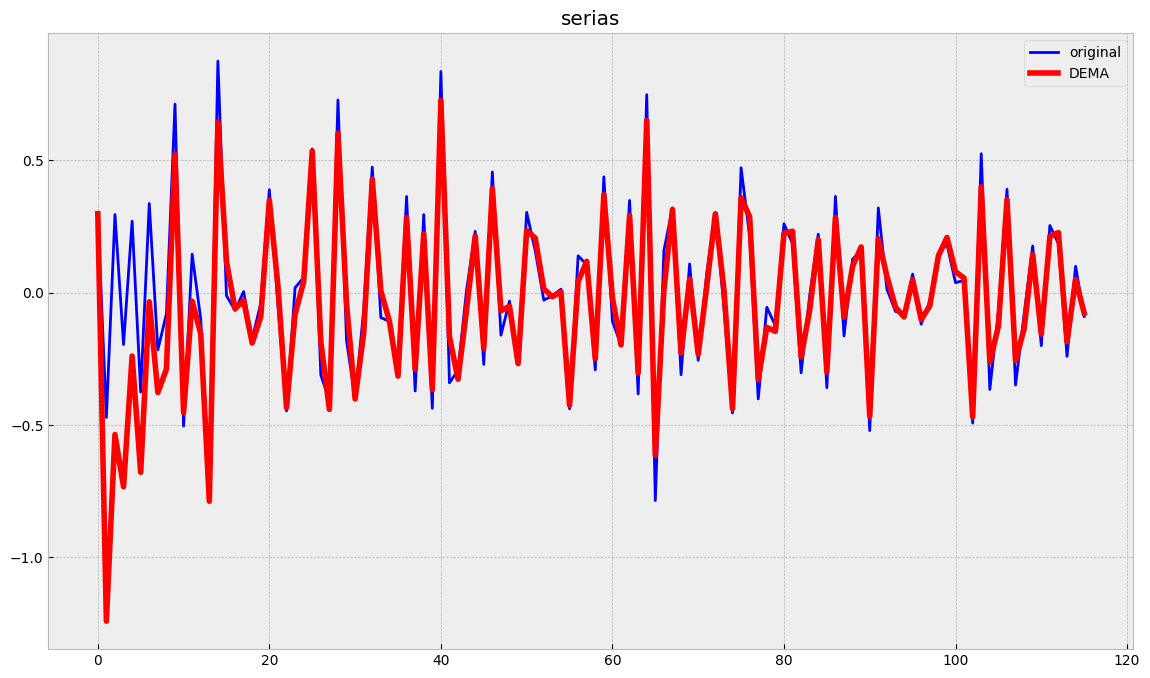

In [107]:
plot_dema(series_stat, 0.8, 0.2)